<a href="https://colab.research.google.com/github/susansunshin/Project-2/blob/main/Project_2_Part_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project 2 Part 4

Susan Shin

Assignment:

* Ensure that you complete the appropriate pre-processing steps.

* Try multiple models and tune the hyperparameters of each model to optimize model performance (include all models and hyperparameters tested in addition to the final model).

* Perform PCA or another feature engineering technique on your dataset to see how this impacts your results. (We encourage you to try multiple techniques depending on your data!).

* Evaluate model performance with appropriate metrics for the model.

* Choose your "production" model and justify this decision.

* Go back through your code and ensure that you have provided clear comments (remember this is for your portfolio!).

* Update your project readme and describe your final model, your final model evaluation metrics, and explain whether or not your model would be useful in production and if so, how it should be used.

* Commit your code to GitHub.

##Load

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [252]:
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, \
precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay, \
classification_report
from sklearn import set_config
set_config(display='diagram')

from dython.nominal import associations
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

In [253]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [254]:
from google.colab import drive
drive.mount('/content/drive')

filename = "/content/sample_data/wines_SPA 3.csv"
df = pd.read_csv(filename)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


#Functions

In [255]:
!pip install dython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [256]:
def eval_regression(true, pred):

  mae = round(mean_absolute_error(true, pred),5)
  mse = round(mean_squared_error(true, pred),5)
  rmse = round(np.sqrt(mse),5)
  r2 = round(r2_score(true, pred),5)

  print(f'MAE: {mae},\n MSE: {mse},\n RMSE: {rmse},\n R^2: {r2}\n ')

#Explore Data

In [257]:
#Make Copy
df_ml = df

In [258]:
#Remove num_reviews
df_ml = df_ml.drop(columns=["num_reviews"])
df_ml.head()

,winery,wine,year,rating,country,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,Espana,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,Espana,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,Espana,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,Espana,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,Espana,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


In [259]:
#Check for Dupes
df_ml.duplicated().sum()

5452

In [260]:
#Drop Dupes
df_ml = df_ml.drop_duplicates()
df_ml.duplicated().sum()

0

In [261]:
#Check for NAs
df_ml.isna().sum()

winery       0
wine         0
year         2
rating       0
country      0
region       0
price        0
type       106
body       271
acidity    271
dtype: int64

In [262]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2048 entries, 0 to 6100
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   winery   2048 non-null   object 
 1   wine     2048 non-null   object 
 2   year     2046 non-null   object 
 3   rating   2048 non-null   float64
 4   country  2048 non-null   object 
 5   region   2048 non-null   object 
 6   price    2048 non-null   float64
 7   type     1942 non-null   object 
 8   body     1777 non-null   float64
 9   acidity  1777 non-null   float64
dtypes: float64(4), object(6)
memory usage: 176.0+ KB


In [263]:
#Check for consistencies for object values
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', -1)
pd.set_option('display.max_rows', None)

dtypes = df_ml.dtypes
str_cols = dtypes[dtypes=='object'].index
str_cols
  
for col in str_cols:
  print(f"- Column= {col}")
  print(df[col].value_counts(dropna=False))
  print('\n\n')

- Column= winery
Contino                                             457
Artadi                                              261
La Rioja Alta                                       254
Sierra Cantabria                                    237
Matarromera                                         232
Vina Pedrosa                                        230
Imperial                                            228
Losada                                              227
Portal del Priorat                                  225
Ramon Bilbao                                        225
Sei Solo                                            225
Matsu                                               224
Bodegas La Horra                                    223
Campillo                                            223
Lustau                                              223
La Vicalanda                                        223
Conreria d'Scala Dei                                223
Mar de Frades                  

The object in year is N.V. - which means Non Vintage. So this is a valid value.

Country is all Spain, no need for this column, will delete.

In [264]:
df_ml = df_ml.drop(columns=['country'])
df_ml.head()

,winery,wine,year,rating,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


In [265]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2048 entries, 0 to 6100
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   winery   2048 non-null   object 
 1   wine     2048 non-null   object 
 2   year     2046 non-null   object 
 3   rating   2048 non-null   float64
 4   region   2048 non-null   object 
 5   price    2048 non-null   float64
 6   type     1942 non-null   object 
 7   body     1777 non-null   float64
 8   acidity  1777 non-null   float64
dtypes: float64(4), object(5)
memory usage: 160.0+ KB


In [266]:
#Check Numerical values for outliers
df_ml["rating"].value_counts()

4.3    706
4.4    484
4.5    281
4.2    228
4.6    191
4.7    112
4.8     44
4.9      2
Name: rating, dtype: int64

In [267]:
df_ml["body"].value_counts()

4.0    1003
5.0     634
3.0     106
2.0      34
Name: body, dtype: int64

In [268]:
df_ml["acidity"].value_counts()

3.0    1672
2.0      70
1.0      35
Name: acidity, dtype: int64

Looking to see what metrics have high correlation.

##Dython correlation heat map

I'm going to create a heat map to see how correlated the numerical values are.

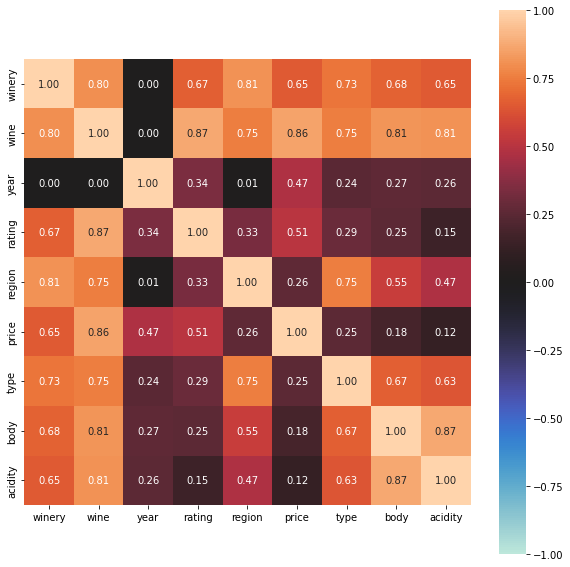

In [269]:
# Explore correlations
associations(df_ml, figsize=(10,10));

I would like to explore price and rating -- mostly because I have heard that prices for wines are arbirtary and don't really have anything to do with the actual taste of the wine.

#Visualization

##Price and Rating

In [270]:
df_ml = df_ml.sort_values("rating")

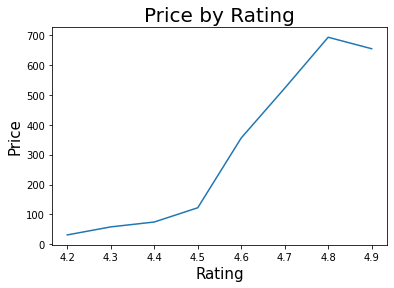

In [271]:
sns.lineplot( data = df_ml, x= "rating", y = "price", ci = None)
plt.title("Price by Rating", size = 20)
plt.xlabel("Rating", size = 15)
plt.ylabel("Price", size = 15);

This graph, although simple, shows a very strong correlation of price vs. rating. 

In other words, the more expensive a bottle of wine is, the higher the rating.

This is definitely something to explore as we go through clustering as there could be imbalanced data sets that are affecting the correlation.

##Type/Price and Rating

Another attribute that I wanted to dig into was the type of wine, and what kind of correlation we can see when it comes to rating.

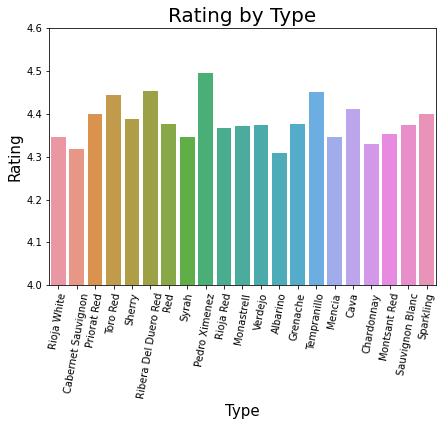

In [272]:
sns.barplot( data = df_ml, x = "type", y = "rating", ci = None)
plt.tight_layout(pad=0)
plt.xticks(rotation = 80, size = 10)
plt.title("Rating by Type", size = 20)
plt.xlabel("Type", size = 15)
plt.ylabel("Rating", size = 15)
plt.ylim(4.0, 4.6);

Based on this bar plot, the type of wine that is highest rated is Pedro Ximenez followed by Ribera Del Duero and Toro red.

This will be a good base to understand the data before applying a model to the data.

##Assortment Deep Dive

Whenver looking at an assortment of product, it's always good to understand the assortment.

In otherwords, how many of each type, price, etc. were tasted. This can often have an effect on the rating, so it's always good to understand what the groupings there were.

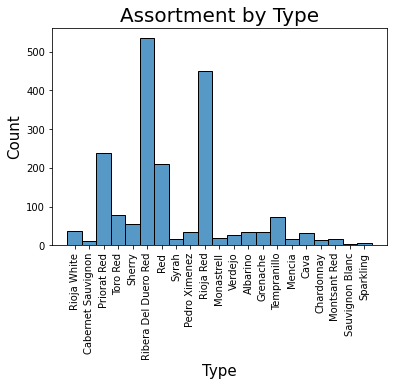

In [273]:
sns.histplot( data = df_ml, x = "type")
plt.xticks(rotation = 90, size = 10)
plt.title("Assortment by Type", size = 20)
plt.xlabel("Type", size = 15)
plt.ylabel("Count", size = 15);

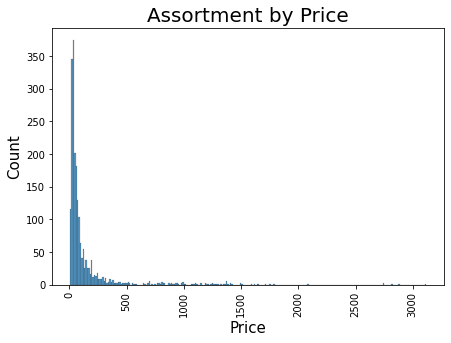

In [274]:
sns.histplot( data = df_ml, x = "price")
plt.tight_layout(pad=0)
plt.xticks(rotation = 90, size = 10)
plt.title("Assortment by Price", size = 20)
plt.xlabel("Price", size = 15)
plt.ylabel("Count", size = 15);

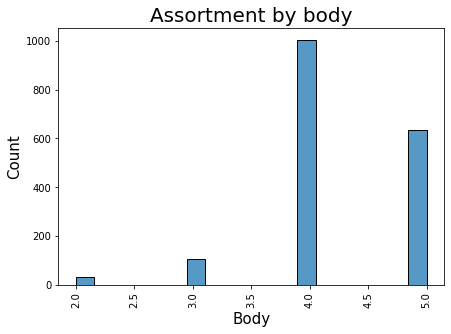

In [275]:
sns.histplot( data = df_ml, x = "body")
plt.tight_layout(pad=0)
plt.xticks(rotation = 90, size = 10)
plt.title("Assortment by body", size = 20)
plt.xlabel("Body", size = 15)
plt.ylabel("Count", size = 15);

#Preprocssing

In [276]:
#Split Data
X = df_ml.drop(columns=["rating"])
y = df_ml["rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [277]:
#Create selectors
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

In [278]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

impute_mean = SimpleImputer(strategy='mean')
freq_imputer = SimpleImputer(strategy='most_frequent')

In [279]:
#Create pipes
num_pipe = make_pipeline(impute_mean, scaler)
cat_pipe = make_pipeline(freq_imputer, ohe)

In [280]:
#Tupes
num_tup = (num_pipe, num_selector)
cat_tup = (cat_pipe, cat_selector)

In [281]:
#Create preprocessor
preprocessor = make_column_transformer(cat_tup, num_tup, remainder = 'drop')
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f944b623f90>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f944b623e50>)])

#**Model Selection**

##Bagging Regressor

In [282]:
#Create Pipe
br = BaggingRegressor(random_state =42)
br_pipe = make_pipeline(preprocessor, br)
br_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f944b623f90>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f944b623e50>)])),
                ('baggingregressor', BaggingRegressor(random_state=42))])

###Tune

In [283]:
br_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f944b623f90>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                 

In [284]:
#Run grid search
br_param_grid = {'baggingregressor__n_estimators': range(1,30)}

br_pipe_gs = GridSearchCV(br_pipe, br_param_grid)
br_pipe_gs.fit(X_train, y_train)
print('Best Parameters:')
print(br_pipe_gs.best_params_)
best_pipe = br_pipe_gs.best_estimator_
print(f'Accuracy of best model is: {best_pipe.score(X_test, y_test)}')

Best Parameters:
{'baggingregressor__n_estimators': 27}
Accuracy of best model is: 0.5173921073110621


In [312]:
#Create tuned model
br_tuned = BaggingRegressor(n_estimators = 27, random_state = 42)
br_pipe_tuned = make_pipeline(preprocessor, br_tuned)
br_pipe_tuned.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f944b623f90>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f944b623e50>)])),
                ('baggingregressor',
                 BaggingRegressor(n_estimators=27, random_state=42))])

###Score

In [313]:
br_test_pred_tuned = br_pipe_tuned.predict(X_test)
br_train_pred_tuned = br_pipe_tuned.predict(X_train)

In [314]:
# evaluate model
br_train_score = eval_regression(y_train, br_train_pred_tuned)
br_test_score = eval_regression(y_test, br_test_pred_tuned)

MAE: 0.02829,
 MSE: 0.00145,
 RMSE: 0.03808,
 R^2: 0.93405
 
MAE: 0.07857,
 MSE: 0.00979,
 RMSE: 0.09894,
 R^2: 0.51739
 


##KNeighbors

In [288]:
#Create Pipe
kn = KNeighborsRegressor()
kn_pipe = make_pipeline(preprocessor, kn)
kn_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f944b623f90>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f944b623e50>)])),
                ('kneighborsregressor', KNeighborsRegressor())])

###Tune

In [289]:
#Get Parameters
kn_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f944b623f90>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                 

In [290]:
#Run grid search
kn_param_grid = {"kneighborsregressor__n_neighbors": range(1,30)}

kn_pipe_gs = GridSearchCV(kn_pipe, kn_param_grid)
kn_pipe_gs.fit(X_train, y_train)
print('Best Parameters:')
print(kn_pipe_gs.best_params_)
best_pipe = kn_pipe_gs.best_estimator_
print(f'Accuracy of best model is: {best_pipe.score(X_test, y_test)}')

Best Parameters:
{'kneighborsregressor__n_neighbors': 7}
Accuracy of best model is: 0.5089435506880879


In [291]:
#Create tuned model
kn_tuned = KNeighborsRegressor(n_neighbors = 7)
kn_pipe_tuned = make_pipeline(preprocessor, kn_tuned)
kn_pipe_tuned.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f944b623f90>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f944b623e50>)])),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=7))])

In [292]:
print(kn_pipe_tuned.score(X_train, y_train))
print(kn_pipe_tuned.score(X_test, y_test))

0.6177503994733425
0.5089435506880879


###Score

In [293]:
kn_test_pred_tuned = kn_pipe_tuned.predict(X_test)
kn_train_pred_tuned = kn_pipe_tuned.predict(X_train)

In [294]:
kn_train_score = eval_regression(y_train, kn_train_pred_tuned)
kn_test_score = eval_regression(y_test, kn_test_pred_tuned)

MAE: 0.07201,
 MSE: 0.00843,
 RMSE: 0.09182,
 R^2: 0.61775
 
MAE: 0.07905,
 MSE: 0.00996,
 RMSE: 0.0998,
 R^2: 0.50894
 


##Random Forest

In [295]:
rf = RandomForestRegressor(random_state = 42)
rf_pipe = make_pipeline(preprocessor, rf)
rf_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f944b623f90>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f944b623e50>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

###Tune

In [296]:
#Get Parameters
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f944b623f90>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                 

In [297]:
#Find max depth
est_depths = [estimator.get_depth() for estimator in rf.estimators_]
max(est_depths)

93

In [298]:
#Run grid search
rf_param_grid = {'randomforestregressor__max_depth': range(1,105)}

rf_pipe_gs = GridSearchCV(rf_pipe, rf_param_grid)
rf_pipe_gs.fit(X_train, y_train)
print('Best Parameters:')
print(rf_pipe_gs.best_params_)
best_pipe = rf_pipe_gs.best_estimator_
print(f'Accuracy of best model is: {best_pipe.score(X_test, y_test)}')

Best Parameters:
{'randomforestregressor__max_depth': 47}
Accuracy of best model is: 0.5315079898821327


In [311]:
#Create tuned pipe
rf_tuned = RandomForestRegressor(max_depth = 47, random_state = 42)
rf_pipe_tuned = make_pipeline(preprocessor, rf)
rf_pipe_tuned.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f944b623f90>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f944b623e50>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [300]:
print(rf_pipe_tuned.score(X_train, y_train))
print(rf_pipe_tuned.score(X_test, y_test))

0.9391478854301596
0.5302055445790271


###Score

In [301]:
rf_test_pred_tuned = rf_pipe_tuned.predict(X_test)
rf_train_pred_tuned = rf_pipe_tuned.predict(X_train)

In [302]:
rf_train_score = eval_regression(y_train, rf_train_pred_tuned)
rf_test_score = eval_regression(y_test, rf_test_pred_tuned)

MAE: 0.02805,
 MSE: 0.00134,
 RMSE: 0.03661,
 R^2: 0.93915
 
MAE: 0.07755,
 MSE: 0.00953,
 RMSE: 0.09762,
 R^2: 0.53021
 


##Comparing all scores

In [315]:
print('Bagging Regressor')
print('Train Score')
br_train_score = eval_regression(y_train, br_train_pred_tuned)
print("Test Score")
br_test_score = eval_regression(y_test, br_test_pred_tuned)

Bagging Regressor
Train Score
MAE: 0.02829,
 MSE: 0.00145,
 RMSE: 0.03808,
 R^2: 0.93405
 
Test Score
MAE: 0.07857,
 MSE: 0.00979,
 RMSE: 0.09894,
 R^2: 0.51739
 


In [316]:
print('KNeighbors Regressor')
print('Train Score')
kn_train_score = eval_regression(y_train, kn_train_pred_tuned)
print("Test Score")
kn_test_score = eval_regression(y_test, kn_test_pred_tuned)

KNeighbors Regressor
Train Score
MAE: 0.07201,
 MSE: 0.00843,
 RMSE: 0.09182,
 R^2: 0.61775
 
Test Score
MAE: 0.07905,
 MSE: 0.00996,
 RMSE: 0.0998,
 R^2: 0.50894
 


In [317]:
print('Random Forest Regressory')
print('Train Score')
rf_train_score = eval_regression(y_train, rf_train_pred_tuned)
print("Test Score")
rf_test_score = eval_regression(y_test, rf_test_pred_tuned)

Random Forest Regressory
Train Score
MAE: 0.02805,
 MSE: 0.00134,
 RMSE: 0.03661,
 R^2: 0.93915
 
Test Score
MAE: 0.07755,
 MSE: 0.00953,
 RMSE: 0.09762,
 R^2: 0.53021
 


KNeighbors has the worse scores so this model will be taken out of the running.

Between Bagging Regressor and Random Forrest, R^2 scores are 0.535 and 0.530. 

For the R^2 score, we want the highest number, so for R^2, Bagging Regressor is slightly better.

Between Bagging Regressor and Random Forest, RMSE scores are 0.0970 and 0.0976.

For the RMSE score, we want to be as close to 0 as possible. That means the Bagging Regressor score is also slightly better.

Based on this I will continue with Bagging Regressor.

#Feature Engineering

##PCA - to speed up model

In [306]:
pca = PCA()

In [307]:
%%time
br_test_pred_tuned = br_pipe_tuned.predict(X_test)

CPU times: user 84.8 ms, sys: 2 ms, total: 86.8 ms
Wall time: 86.4 ms


In [308]:
#Create tuned model
br_pipe_tuned_pca = make_pipeline(preprocessor, pca, br_tuned)
br_pipe_tuned_pca.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f944b623f90>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f944b623e50>)])),
                ('pca', PCA()),
                ('baggingregressor',
                 BaggingRegressor(n_estimators=24, random_state=42))])

In [309]:
%%time
br_train_pred_tuned_pca = br_pipe_tuned_pca.predict(X_train)

CPU times: user 574 ms, sys: 122 ms, total: 696 ms
Wall time: 442 ms


PCA actually made the time longer. I looked this up and it seems as though PCA is only good for continuous data. While it's possible to use PCA on OHE data, it doesn't necissarily make the run time better.

Because of this, I will not apply PCA to this model.

##Combining columns

Based on the dython heat map, the highest correlation with rating are winery and wine. Let's try combining these to see if it helps with the scores.

In [310]:
df_fe = df_ml
df_fe.head()

,winery,wine,year,rating,region,price,type,body,acidity
6100,Remirez de Ganuza,Rioja Blanco,2017,4.2,Rioja,29.15,Rioja White,NaN,NaN
1902,Familia Torres,Mas La Plana Cabernet Sauvignon,2016,4.2,Penedes,56.26,Cabernet Sauvignon,4.0,3.0
1901,Merum Priorati,Inici,2017,4.2,Priorato,39.00,Priorat Red,4.0,3.0
1900,Alvaro Palacios,Les Terrasses Laderas de Pizarra,2016,4.2,Priorato,32.25,Priorat Red,4.0,3.0
1899,Bodega Numanthia,Numanthia,2013,4.2,Toro,51.19,Toro Red,5.0,3.0


In [318]:
df_fe['Wine & Winery'] = df['wine'] + df['winery']
df_fe.drop(columns=['wine','winery'], inplace= True)
df_fe.head()

,year,rating,region,price,type,body,acidity,Wine & Winery
6100,2017,4.2,Rioja,29.15,Rioja White,NaN,NaN,Rioja BlancoRemirez de Ganuza
1902,2016,4.2,Penedes,56.26,Cabernet Sauvignon,4.0,3.0,Mas La Plana Cabernet SauvignonFamilia Torres
1901,2017,4.2,Priorato,39.00,Priorat Red,4.0,3.0,IniciMerum Priorati
1900,2016,4.2,Priorato,32.25,Priorat Red,4.0,3.0,Les Terrasses Laderas de PizarraAlvaro Palacios
1899,2013,4.2,Toro,51.19,Toro Red,5.0,3.0,NumanthiaBodega Numanthia


I will also combine acidity and body - since these are two things that are used to describe the taste of wine.

In [319]:
df_fe['flavor profile'] = df['body'] + df['acidity']
df_fe.drop(columns=['body','acidity'], inplace= True)
df_fe.head()

,year,rating,region,price,type,Wine & Winery,flavor profile
6100,2017,4.2,Rioja,29.15,Rioja White,Rioja BlancoRemirez de Ganuza,NaN
1902,2016,4.2,Penedes,56.26,Cabernet Sauvignon,Mas La Plana Cabernet SauvignonFamilia Torres,7.0
1901,2017,4.2,Priorato,39.00,Priorat Red,IniciMerum Priorati,7.0
1900,2016,4.2,Priorato,32.25,Priorat Red,Les Terrasses Laderas de PizarraAlvaro Palacios,7.0
1899,2013,4.2,Toro,51.19,Toro Red,NumanthiaBodega Numanthia,8.0


##Rerun Model

In [320]:
#Split Data
X = df_fe.drop(columns=["rating"])
y = df_fe["rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [321]:
#Create selectors
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

In [322]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

impute_mean = SimpleImputer(strategy='mean')
freq_imputer = SimpleImputer(strategy='most_frequent')

In [323]:
#Create pipes
num_pipe = make_pipeline(impute_mean, scaler)
cat_pipe = make_pipeline(freq_imputer, ohe)

In [324]:
#Tupes
num_tup = (num_pipe, num_selector)
cat_tup = (cat_pipe, cat_selector)

In [325]:
#Create preprocessor
preprocessor = make_column_transformer(cat_tup, num_tup, remainder = 'drop')
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f944bf194d0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f944bf19a50>)])

In [327]:
#Create Pipe
br2 = BaggingRegressor(n_estimators = 27, random_state =42)
br2_pipe = make_pipeline(preprocessor, br2)
br2_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f944bf194d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f944bf19a50>)])),
                ('baggingregressor',
                 BaggingRegressor(n_estimators=27, random_state=42))])

##Score

In [329]:
br2_test_pred_tuned = br2_pipe.predict(X_test)
br2_train_pred_tuned = br2_pipe.predict(X_train)

In [330]:
# evaluate model
br2_train_score = eval_regression(y_train, br2_train_pred_tuned)
br2_test_score = eval_regression(y_test, br2_test_pred_tuned)

MAE: 0.02847,
 MSE: 0.00146,
 RMSE: 0.03821,
 R^2: 0.93381
 
MAE: 0.07894,
 MSE: 0.00966,
 RMSE: 0.09829,
 R^2: 0.5238
 


Combining columns slightly helped with the scores for the Bagging Regressory Model.